### **MDS7104: Aprendizaje de Máquinas**

**Magíster en Ciencia de Datos Universidad de Chile**

**Profesor:** Felipe Tobar

**Ayuxiliares:** Catherine Benavides, Camila Bergasa, Víctor Caro, Camilo Carvajal Reyes, Diego Cortez M., Stefano Schiappacasse

# Modelos de función de base adaptativa

Este notebook es una pequeña demostración del uso de modelos de árboles, boosting, bosques aleatorios y boosting. Fue desarrollado por Camilo Carvajal Reyes tomando muchos elementos del Auxiliar 7 2023 desarrollado por Diego Cortés. En particular este notebook genera las figuras del apunte para la unidad **Modelos de función de base adaptativa**.

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)


Motivación: árboles de regresión.

In [2]:
def samplear_gaussianas(N,mu=0,sd=7.5):
    # retorna un vector de tamaño N con realizaciones de una v.a. Gaussiana
    return np.random.normal(loc=mu,scale=sd,size=N)

In [3]:
data = np.loadtxt('../datos/gauss2.csv')
X = data[:, 1]
eps = samplear_gaussianas(X.shape[0])
y = data[:, 0] + eps

In [4]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

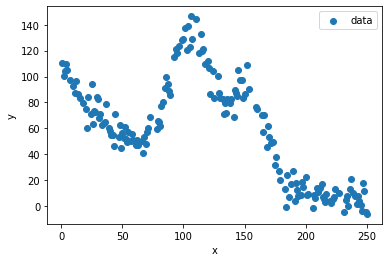

In [5]:
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(X,y,label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.plot();

Usando los datos, ajustaremos dos árboles. Uno corresponde a un árbol sin límite de profundidad (que por ende terminará sobre-ajustado) y uno con profundidad 4 (que parece ser una mejor aproximación de la función, por inspección).

In [6]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = DecisionTreeRegressor()
regr_1.fit(X.reshape(-1, 1), y.reshape(-1, 1))
regr_2.fit(X.reshape(-1, 1), y.reshape(-1, 1))

DecisionTreeRegressor()

In [7]:
X_test = np.arange(0.0, 250.0, 1)
y_1 = regr_1.predict(X_test.reshape(-1, 1))
y_2 = regr_2.predict(X_test.reshape(-1, 1))

Primeramente plotearemos un árbol de profundidad "cero". Esto corresponde a asignar la media de todo el conjunto como predicción. Acá el nodo del árbol representa la partición trivial: el único subconjunto es todo el conjunto.

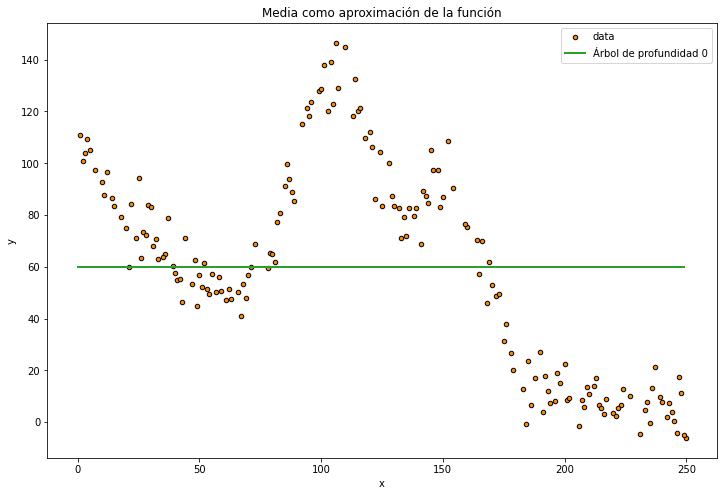

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
mean = y.mean()
y_3 = np.ones_like(X_test)*mean
plt.plot(X_test, y_3, color="tab:green", label="Árbol de profundidad 0", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Media como aproximación de la función")
plt.legend()
plt.show()

Contrastand con lo anterior, no parar nunca de cortar un árbol termina por sobreajustarlo:

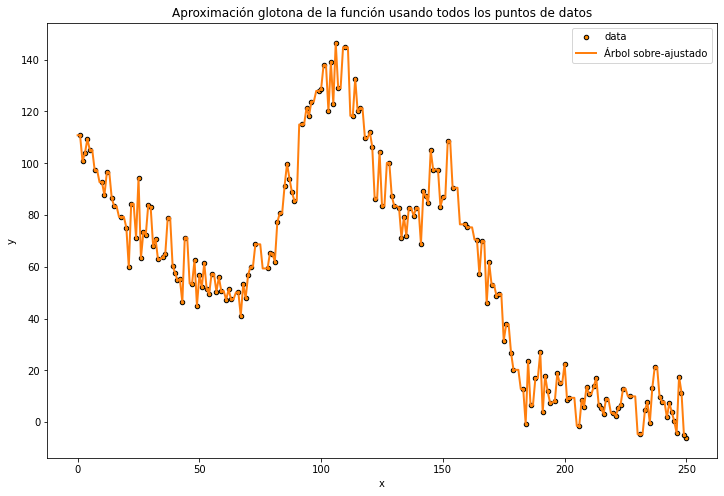

In [9]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_2, color="tab:orange", label="Árbol sobre-ajustado", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Aproximación glotona de la función usando todos los puntos de datos")
plt.legend()
plt.show()

Idealmente tendremos una profundidad que permita generalizar bien a distintas regiones del soporte de la función.

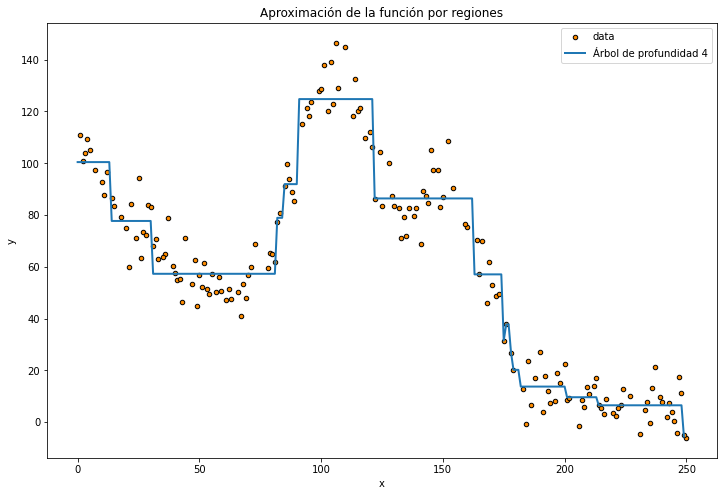

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="tab:blue", label="Árbol de profundidad 4", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Aproximación de la función por regiones")
plt.legend()
plt.show()

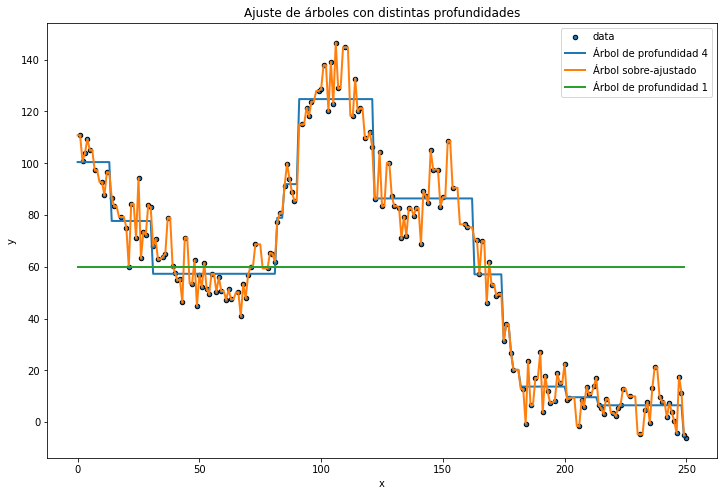

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black", label="data")
plt.plot(X_test, y_1, label="Árbol de profundidad 4", linewidth=2)
plt.plot(X_test, y_2, label="Árbol sobre-ajustado", linewidth=2)
plt.plot(X_test, y_3, label="Árbol de profundidad 1", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Ajuste de árboles con distintas profundidades")
plt.legend()
plt.show()